In [3]:
!pip install pydot

In [2]:
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import os

import tensorflow as tf
#print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import BatchNormalization, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Activation
from keras.models import Sequential
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping

import cv2
from random import sample
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [3]:
all_img_data = pd.read_csv("data_labels_mainData.csv")
all_img_path = {os.path.basename(x) : x for x in
               glob(os.path.join("./patch_images","*.png"))}
print("Total Images found in image directory:", len(all_img_path), ", Total images in main CSV file" , all_img_data.shape[0])
all_img_data["imagePath"] = all_img_data["ImageName"].map(all_img_path.get)

# Classifiing the cell type
OUTPUT_CLASSES = 4

Total Images found in image directory: 20280 , Total images in main CSV file 9896


In [4]:
all_img_data.sample(10)

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous,imagePath
157,18923,3,18923.png,inflammatory,1,0,./patch_images/18923.png
8888,13979,54,13979.png,epithelial,2,1,./patch_images/13979.png
6540,9920,41,9920.png,inflammatory,1,0,./patch_images/9920.png
5208,17069,29,17069.png,inflammatory,1,0,./patch_images/17069.png
6704,10089,41,10089.png,epithelial,2,1,./patch_images/10089.png
9457,21179,57,21179.png,inflammatory,1,0,./patch_images/21179.png
5611,11983,31,11983.png,epithelial,2,1,./patch_images/11983.png
4102,4340,22,4340.png,epithelial,2,1,./patch_images/4340.png
4207,4451,22,4451.png,epithelial,2,1,./patch_images/4451.png
3026,8966,17,8966.png,epithelial,2,1,./patch_images/8966.png


In [5]:
train_data, test_data = train_test_split(all_img_data, test_size=0.2, random_state=0)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=0)

print(f"Train data: {train_data.shape[0]}, Test data: {test_data.shape[0]}, Validation Data: {val_data.shape[0]}")

Train data: 5937, Test data: 1980, Validation Data: 1979


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
            dataframe=train_data,
            directory='./',
            x_col="imagePath",
            y_col="cellTypeName",
            target_size=(27,27),
            batch_size=batch_size,
            class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
            dataframe=val_data,
            directory='./',
            x_col="imagePath",
            y_col="cellTypeName",
            target_size=(27,27),
            batch_size=batch_size,
            class_mode='categorical')

Found 5937 validated image filenames belonging to 4 classes.
Found 1979 validated image filenames belonging to 4 classes.


In [9]:
# RCCNet arciturture
model = Sequential()

model.add(Conv2D(filters=32,kernel_size=(3,3), activation='relu', padding='same', input_shape=(27,27,3)))
model.add(BatchNormalization())
model.add(Conv2D(32,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64,(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64,(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(4,activation='softmax'))


model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 27, 27, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 27, 27, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 25, 25, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 12, 12, 64)       

In [7]:
tf.keras.utils.plot_model(model, show_shapes=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [10]:
optimizer = Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, decay=1.0e-6)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# define callbacks
weight_path="{}_model.best.hdf5".format('CellTypeName')
checkpoint = ModelCheckpoint(weight_path, monitor = 'val_loss', mode = 'min', verbose = 1, save_best_only = True, save_weights_only = True)
early = EarlyStopping(monitor = 'val_loss', mode = 'min', patience=10)
callbacks_list = [checkpoint, early]

In [11]:
history = model.fit(
        train_generator,
        validation_data= validation_generator,
        epochs=100,
        verbose=0,
        callbacks=callbacks_list)


Epoch 00001: val_loss improved from inf to 1.72828, saving model to CellTypeName_model.best.hdf5

Epoch 00002: val_loss improved from 1.72828 to 1.56389, saving model to CellTypeName_model.best.hdf5

Epoch 00003: val_loss improved from 1.56389 to 0.97193, saving model to CellTypeName_model.best.hdf5

Epoch 00004: val_loss improved from 0.97193 to 0.83503, saving model to CellTypeName_model.best.hdf5

Epoch 00005: val_loss improved from 0.83503 to 0.82781, saving model to CellTypeName_model.best.hdf5

Epoch 00006: val_loss improved from 0.82781 to 0.80593, saving model to CellTypeName_model.best.hdf5

Epoch 00007: val_loss improved from 0.80593 to 0.80037, saving model to CellTypeName_model.best.hdf5

Epoch 00008: val_loss improved from 0.80037 to 0.78616, saving model to CellTypeName_model.best.hdf5

Epoch 00009: val_loss improved from 0.78616 to 0.77571, saving model to CellTypeName_model.best.hdf5

Epoch 00010: val_loss improved from 0.77571 to 0.76969, saving model to CellTypeName_

In [6]:
def plot_history(history):
    
    f = plt.figure()
    f.set_figwidth(10)
    f.add_subplot(1, 2, 1)
    plt.plot(history.history['val_loss'], label='val loss')
    plt.plot(history.history['loss'], label='train loss')
    plt.legend()

    f.add_subplot(1, 2, 2)
    plt.plot(history.history['val_categorical_accuracy'], label='val accuracy')
    plt.plot(history.history['categorical_accuracy'], label='train accuracy')
    plt.legend()

    plt.show()

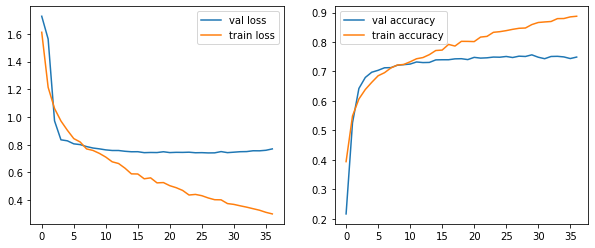

In [13]:
plot_history(history)

In [7]:
#Data Augmentation
batch_size = 32
train_img_aug = ImageDataGenerator(rescale=1.0/255.0,
                            horizontal_flip=True,
                            vertical_flip=True,
                            shear_range=0.2,
                            zoom_range=0.2,
                            data_format='channels_last',
                            rotation_range=15)
val_img_aug = ImageDataGenerator(rescale=1.0/255.0)


train_generator = train_img_aug.flow_from_dataframe(
            dataframe=train_data,
            directory='./',
            x_col="imagePath",
            y_col="cellTypeName",
            target_size=(27,27),
            class_mode='categorical')

validation_generator = val_img_aug.flow_from_dataframe(
            dataframe=val_data,
            directory='./',
            x_col="imagePath",
            y_col="cellTypeName",
            target_size=(27,27),
            class_mode='categorical')

Found 5937 validated image filenames belonging to 4 classes.
Found 1979 validated image filenames belonging to 4 classes.


In [8]:
reg_lambda = 0.001
#RCCNet Model
model = Sequential()

model.add(Conv2D(filters=32,kernel_size=(3,3), activation='relu', padding='same', input_shape=(27,27,3),kernel_regularizer=tf.keras.regularizers.l2(reg_lambda) ))
model.add(BatchNormalization())
model.add(Conv2D(32,(3,3),activation='relu',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64,(3,3), activation='relu', padding='same',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)))
model.add(BatchNormalization())
model.add(Conv2D(64,(3,3), activation='relu',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(512,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(4,activation='softmax'))

In [9]:
optimizer = Adam(lr=1e-5)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# define callbacks
weight_path="{}_model.best.hdf5".format('CellTypeName')
checkpoint = ModelCheckpoint(weight_path, monitor = 'val_loss', mode = 'min', verbose = 1, save_best_only = True, save_weights_only = True)
early = EarlyStopping(monitor = 'val_loss', mode = 'min', patience=10)
callbacks_list = [checkpoint, early]

In [10]:
history = model.fit_generator(
        train_generator,
        validation_data= validation_generator,
        epochs=500,
        verbose=0,
        callbacks=callbacks_list)

Instructions for updating:
Please use Model.fit, which supports generators.

Epoch 00001: val_loss improved from inf to 3.08148, saving model to CellTypeName_model.best.hdf5

Epoch 00002: val_loss did not improve from 3.08148

Epoch 00003: val_loss improved from 3.08148 to 2.37445, saving model to CellTypeName_model.best.hdf5

Epoch 00004: val_loss improved from 2.37445 to 2.27355, saving model to CellTypeName_model.best.hdf5

Epoch 00005: val_loss improved from 2.27355 to 2.24044, saving model to CellTypeName_model.best.hdf5

Epoch 00006: val_loss improved from 2.24044 to 2.19214, saving model to CellTypeName_model.best.hdf5

Epoch 00007: val_loss did not improve from 2.19214

Epoch 00008: val_loss improved from 2.19214 to 2.17529, saving model to CellTypeName_model.best.hdf5

Epoch 00009: val_loss improved from 2.17529 to 2.16358, saving model to CellTypeName_model.best.hdf5

Epoch 00010: val_loss improved from 2.16358 to 2.14362, saving model to CellTypeName_model.best.hdf5

Epoch 0

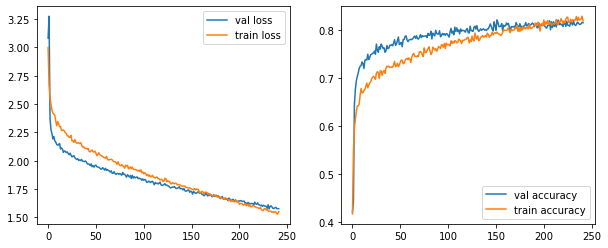

In [11]:
plot_history(history)

In [13]:
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size_t = 1

# Here the validation is used for testing and this should be changes to a separate test set.
test_generator = train_img_aug.flow_from_dataframe(
        dataframe=test_data,
        directory='./',
        x_col="imagePath",
        y_col="cellTypeName",
        target_size=(27, 27),
        batch_size=batch_size_t,
        class_mode='categorical')

Found 1980 validated image filenames belonging to 4 classes.


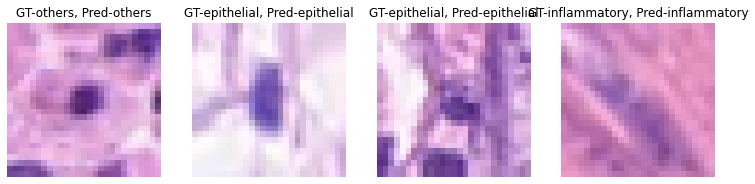

In [15]:
d = {'fibroblast':0, 'inflammatory':1, 'epithelial':2, 'others':3}
d_inv = {v: k for k, v in d.items()}
plt.figure(figsize=(16,4))
batches = 0 
for x,y in test_generator:
    batches = batches + 1
    y_hat = model.predict(x, verbose = 0)
    x = np.squeeze(x)
    if batches < 5:
        plt.subplot(1,5,batches)
        plt.imshow(x)
        plt.title(f"GT-{d_inv[np.argmax(y[0])]}, Pred-{d_inv[np.argmax(y_hat[0])]}")
    else:
        break
        
    plt.axis('off')

In [7]:
extra_img = pd.read_csv("data_labels_extraData.csv")
extra_img.head()

,InstanceID,patientID,ImageName,isCancerous
0,12681,61,12681.png,0
1,12682,61,12682.png,0
2,12683,61,12683.png,0
3,12684,61,12684.png,0
4,12685,61,12685.png,0


In [9]:
extra_img_path = {os.path.basename(x) : x for x in
               glob(os.path.join("./patch_images","*.png"))}
print("Total Images found in image directory:", len(extra_img_path), ", Total images in main CSV file" , extra_img.shape[0])
extra_img["imagePath"] = extra_img["ImageName"].map(extra_img_path.get)

extra_img = extra_img["imagePath"]
extra_img.head()

Total Images found in image directory: 20280 , Total images in main CSV file 10384


0    ./patch_images/12681.png
1    ./patch_images/12682.png
2    ./patch_images/12683.png
3    ./patch_images/12684.png
4    ./patch_images/12685.png
Name: imagePath, dtype: object

In [2]:
model.load_weights(weight_path)
labled_data = model.predict(extra_img)


NameError: name 'model' is not defined